In [1]:
import numpy as np
import keras
import random
import matplotlib.pyplot as plt 
from keras.models import Sequential 
from keras.layers import Dense, LSTM, Dropout
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import keras.backend as K
import scipy.stats as stats
import math

In [2]:
baseline = 0.8
loss_alpha = 0.9
rnn_lr = 0.01 
rnn_decay = 0.1
no_of_nas_epochs = 10
no_of_samples_per_epoch = 10
max_no_of_layers = 6
rnn_dim = 100
rnn_train_epochs = 100
search_space = np.linspace(1,572,572)

In [3]:
def plot_distribution(samples, prob, next_):
    fig = plt.figure(figsize=(20, 2))
    plt.title("Last token of epoch")
    plt.plot(samples, prob)
    plt.axvline(x=next_, c="r")
    plt.axis('off')
    plt.show()

In [4]:
def performance_estimate(sequence):
    break_point = (500, 0.6)
    x = np.max(sequence) - np.min(sequence)
    if x < break_point[0]:
        y = (((break_point[1]-0.51) / (break_point[0]-0)) * (x-0)) + 0.51 
    else:
        y = (((0.99-break_point[1]) / (572-break_point[0])) * (x-break_point[0])) + break_point[1]
    return np.array([y])

In [5]:
def discount_reward(rewards):
    discounted_reward = np.zeros_like(rewards, dtype=np.float32)
    for t in range(len(rewards)):
        dis_reward = 0
        for i, r in enumerate(rewards[t:]):
            dis_reward = loss_alpha**(i-t) * r
        discounted_reward[t] = dis_reward
    if len(rewards) > 1:
        discounted_reward = (discounted_reward - discounted_reward.mean()) / discounted_reward.std()
    return discounted_reward

In [6]:
def reinforce(y_true, y_pred):
    rewards = data_acc - baseline
    discounted_rewards = discount_reward(rewards)
    y_pred = keras.backend.clip(y_pred, 1e-36, 1e36)
    loss = - K.log(y_pred) * discounted_rewards[:, None]
    return loss

In [7]:
model = None
main_input = keras.engine.input_layer.Input(shape=(None, max_no_of_layers-1), batch_shape=None, name="main_input")
x = keras.layers.LSTM(rnn_dim, return_sequences=True)(main_input)
x = keras.layers.LSTM(rnn_dim, return_sequences=True)(x)
main_output = keras.layers.Dense(len(search_space), activation="softmax", name="main_output")(x)
model = keras.models.Model(inputs=[main_input], outputs=[main_output])

In [8]:
model.compile(loss={"main_output": reinforce}, optimizer=keras.optimizers.Adam(lr=rnn_lr, decay=rnn_decay, clipnorm=1.0))

In [9]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      [(None, None, 5)]         0         
_________________________________________________________________
lstm (LSTM)                  (None, None, 100)         42400     
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 100)         80400     
_________________________________________________________________
main_output (Dense)          (None, None, 572)         57772     
Total params: 180,572
Trainable params: 180,572
Non-trainable params: 0
_________________________________________________________________


NAS epoch 1
Epoch average accuracy (10 sequences): 0.703


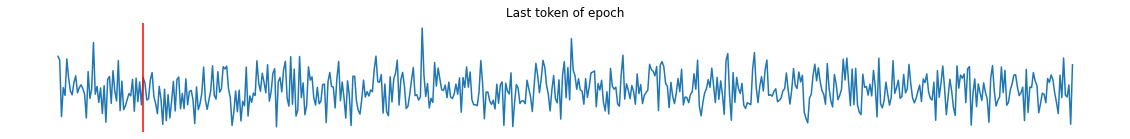

Training lstm ..
lstm loss (epochs average): 0.0003538894204803533
NAS epoch 2
Epoch average accuracy (10 sequences): 0.742


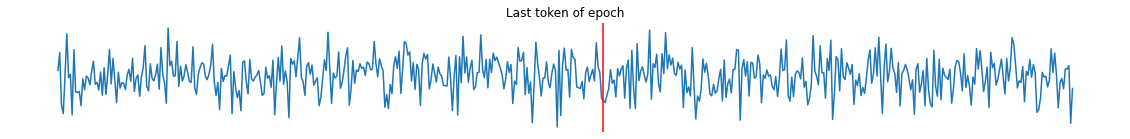

Training lstm ..
lstm loss (epochs average): 1.8352763752318425e-05
NAS epoch 3
Epoch average accuracy (10 sequences): 0.65


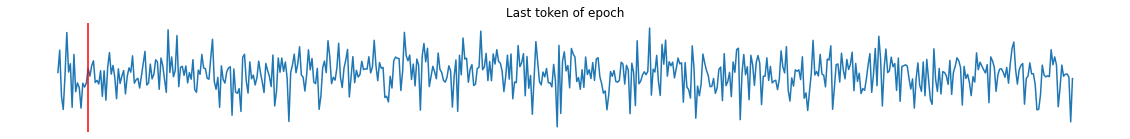

Training lstm ..
lstm loss (epochs average): -4.612731869201525e-05
NAS epoch 4
Epoch average accuracy (10 sequences): 0.664


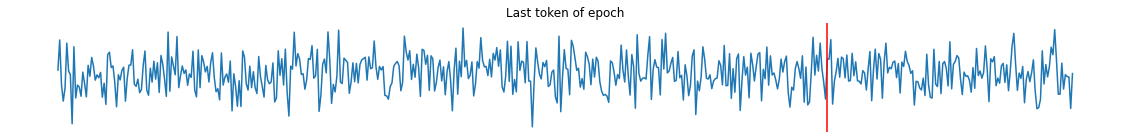

Training lstm ..
lstm loss (epochs average): 2.6178498956141993e-05
NAS epoch 5
Epoch average accuracy (10 sequences): 0.726


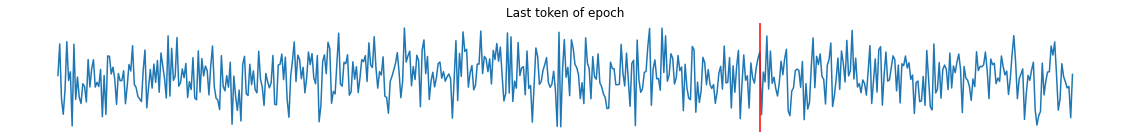

Training lstm ..
lstm loss (epochs average): 1.3791079516352055e-05
NAS epoch 6
Epoch average accuracy (10 sequences): 0.732


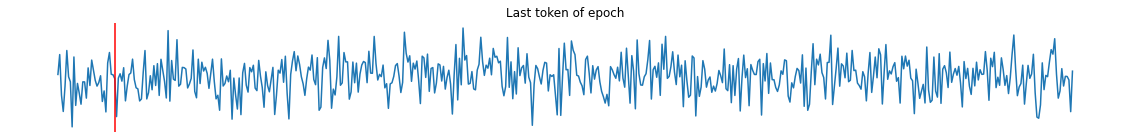

Training lstm ..
lstm loss (epochs average): 1.792306833976909e-05
NAS epoch 7
Epoch average accuracy (10 sequences): 0.78


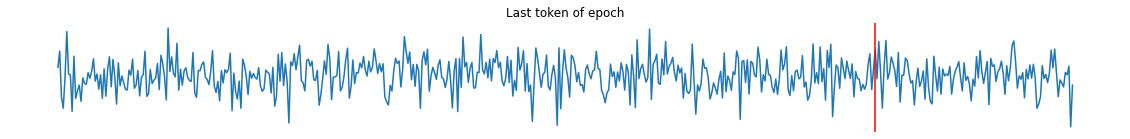

Training lstm ..
lstm loss (epochs average): -1.2380790411725683e-06
NAS epoch 8
Epoch average accuracy (10 sequences): 0.716


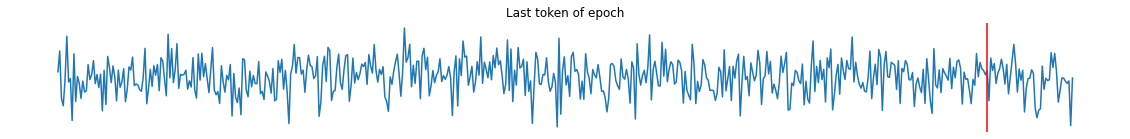

Training lstm ..
lstm loss (epochs average): -1.9396745599351562e-05
NAS epoch 9
Epoch average accuracy (10 sequences): 0.75


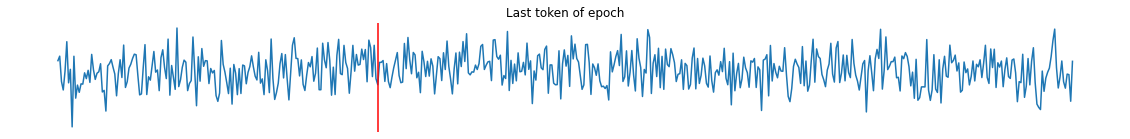

Training lstm ..
lstm loss (epochs average): 1.650698337130052e-06
NAS epoch 10
Epoch average accuracy (10 sequences): 0.729


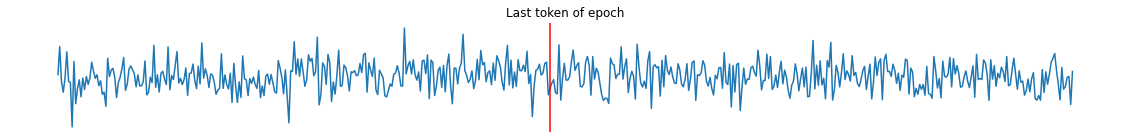

Training lstm ..
lstm loss (epochs average): -8.991527328614524e-06
Done.


In [10]:
history_data_x = []
history_data_acc = []
history_lstm_loss = []
history_avg_acc = []

for nas_epoch in range(no_of_nas_epochs):
    sequences = []
    data_x = None
    accuracies = []
    data_acc = None
    print("NAS epoch", nas_epoch+1)
    for sample_seq in range(no_of_samples_per_epoch):
        sequence = np.zeros((1,1,max_no_of_layers-1), dtype="int32")
        for layer in range(max_no_of_layers-1):
            distribution = model.predict(sequence)
            prob = distribution[0][0]
            selected = np.random.choice(search_space, size=1, p=prob)[0]
            if not selected == 0:
                sequence[0][0][layer] = selected
                
        sequence = sequence[0][0].tolist()
        sequence = sequence + [search_space[-1]]
        if sequence not in sequences:
            sequences.append(sequence)

        sequence_acc = performance_estimate(sequence)
        accuracies.append(sequence_acc)
        data_acc = np.vstack(accuracies)
    
    avg_acc = round(np.average(accuracies),3)
    print(f"Epoch average accuracy ({no_of_samples_per_epoch} sequences):", avg_acc)
    plot_distribution(search_space, prob, selected)
    print("Training lstm ..")
    data_x = np.array(sequences)[:, :-1].reshape(len(sequences), 1, max_no_of_layers-1)
    data_y = to_categorical(np.array(sequences)[:, -1], len(search_space)+1).reshape(len(sequences), 1, len(search_space)+1)
    history = model.fit({'main_input': data_x},
                        {'main_output': data_y},
                        epochs=rnn_train_epochs,
                        batch_size=len(data_x),
                        verbose=0)
    lstm_loss_avg = np.average(list(history.history.values())[0])
    print("lstm loss (epochs average):", lstm_loss_avg)
    
    history_avg_acc.append(avg_acc)
    history_lstm_loss.append(lstm_loss_avg)
    history_data_x.append(data_x)
    history_data_acc.append(data_acc)   
print("Done.")

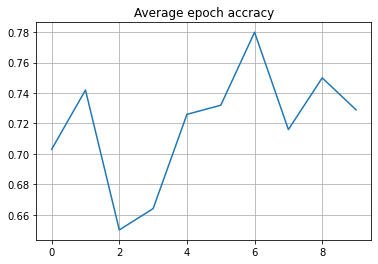

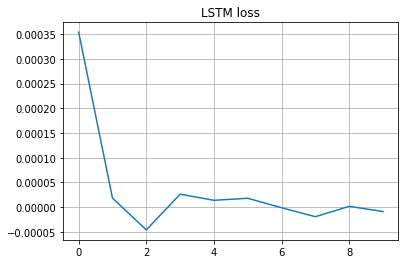

In [11]:
plt.plot(np.arange(0,len(history_avg_acc)), history_avg_acc)
plt.title("Average epoch accracy")
plt.grid()
plt.show()
plt.plot(np.arange(0,len(history_lstm_loss)), history_lstm_loss)
plt.title("LSTM loss")
plt.grid()
plt.show()

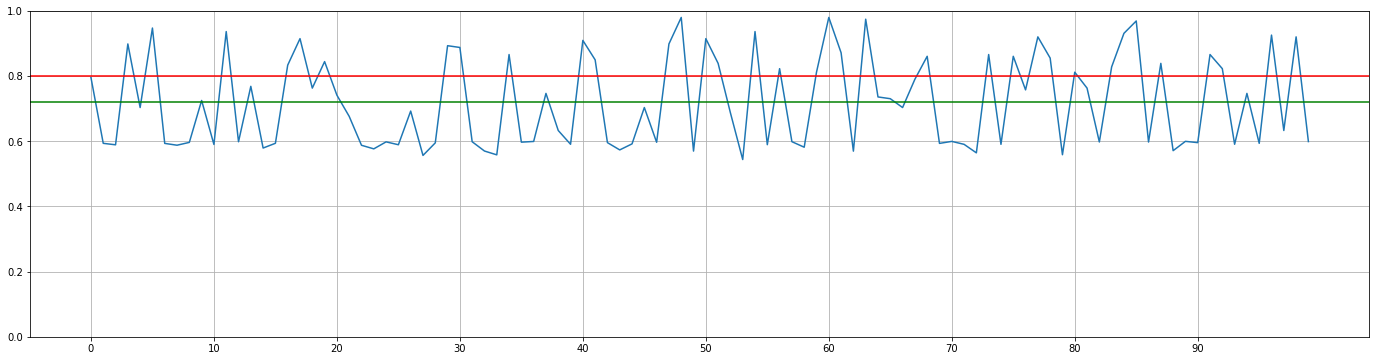

Total accuracy average: 0.7192365666666667


In [12]:
all_acc = np.array(history_data_acc)
all_acc = all_acc.reshape(all_acc.shape[0]*all_acc.shape[1],1)

fig = plt.figure(figsize=(24, 6))
plt.plot(np.arange(0,len(all_acc)), all_acc)
plt.ylim([0,1])
plt.grid()
plt.xticks(range(0,len(all_acc), no_of_samples_per_epoch))
plt.axhline(y=baseline, c="r")
plt.axhline(y=np.average(all_acc), c="g")
plt.show()
print("Total accuracy average:", np.average(all_acc))

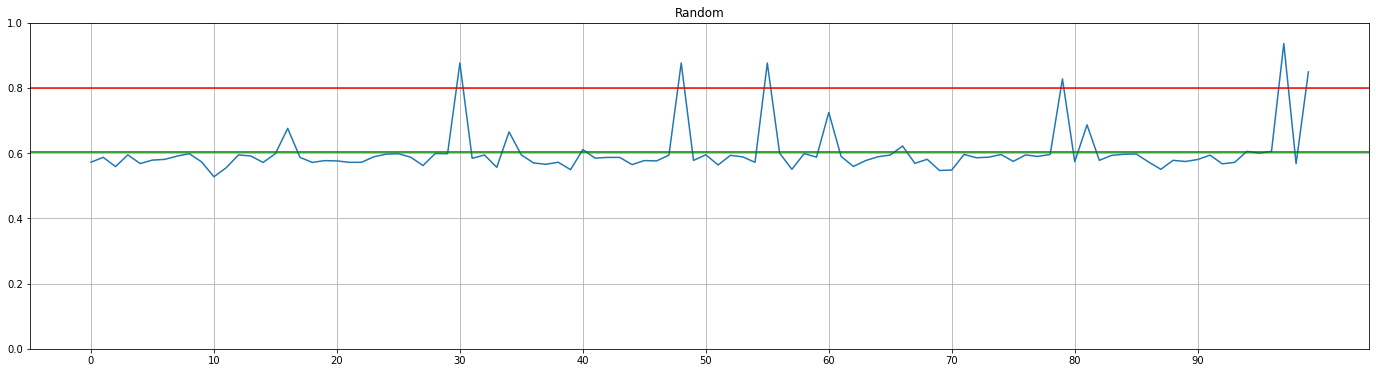

0.6030902666666667


In [19]:
random_acc = []
for i in range(len(all_acc)):
    random_acc.append(performance_estimate(np.random.randint(low=1, high=len(search_space), size=max_no_of_layers)))

fig = plt.figure(figsize=(24, 6))
plt.plot(np.arange(0,len(random_acc)), random_acc)
plt.ylim([0,1])
plt.grid()
plt.xticks(range(0,len(all_acc), no_of_samples_per_epoch))
plt.axhline(y=baseline, c="r")
plt.axhline(y=np.average(random_acc), c="g")
plt.title("Random")
plt.show()
print(np.average(random_acc))